## 18/02/2019

- Comparing the performance of classification models trained on augmented data.

In [1]:
# Import necessary modules. Set settings. Import data.
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from epdata_tools import epdata_main, get_ep_features, get_ep_feature_dict
from IPython.display import HTML

from Augmentation import data_augmentation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm, naive_bayes, neighbors, gaussian_process
from sklearn.gaussian_process.kernels import RBF
import xgboost

from IPython.display import display, clear_output
import pdb

plt.style.use('default')

X_compact = pd.read_pickle('/Users/matthewashman/github/MasterProject2018/Data/X_af_compact.pkl')

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
X_compact.head()

,CS1-2,CS3-4,CS5-6,CS7-8,Coupling Interval,Label,Patient,S1/S2,Type
0,"[-903.0, -873.0, -935.0, -941.0, -910.0, -845....","[298.0, 292.0, 303.0, 311.0, 299.0, 395.0, 451...","[1776.0, 2220.0, 1790.0, -4058.0, -15027.0, -2...","[6283.0, 6464.0, 5952.0, 4507.0, 3694.0, 2873....",340,NaN,1,S1,af
1,"[-931.0, -896.0, -896.0, -906.0, -858.0, -839....","[339.0, 328.0, 348.0, 328.0, 299.0, 361.0, 349...","[1678.0, 2049.0, 2080.0, -1681.0, -11648.0, -1...","[6161.0, 6208.0, 5897.0, 4703.0, 3732.0, 2980....",340,NaN,1,S1,af
2,"[-931.0, -896.0, -896.0, -906.0, -858.0, -839....","[339.0, 328.0, 348.0, 328.0, 299.0, 361.0, 349...","[1678.0, 2049.0, 2080.0, -1681.0, -11648.0, -1...","[6161.0, 6208.0, 5897.0, 4703.0, 3732.0, 2980....",340,NaN,1,S1,af
3,"[-985.0, -925.0, -943.0, -919.0, -935.0, -877....","[255.0, 287.0, 321.0, 335.0, 396.0, 400.0, 491...","[2053.0, 2296.0, -448.0, -11020.0, -19196.0, -...","[5944.0, 5725.0, 4579.0, 3615.0, 2952.0, 1393....",330,NaN,1,S1,af
4,"[-1025.0, -913.0, -885.0, -903.0, -864.0, -947...","[262.0, 285.0, 336.0, 349.0, 342.0, 490.0, 506...","[1726.0, 2111.0, 2289.0, -736.0, -11322.0, -19...","[6270.0, 6584.0, 6191.0, 4876.0, 3749.0, 2986....",330,NaN,1,S1,af


In [3]:
# %matplotlib qt 
# Create new augmented data for each S2 row of X_compact
X_compact['Augmented'] = 0
# Use for storing augmented_rows in the form of dicts
augmented_list = []
for _, row in X_compact[X_compact['S1/S2']=='S2'].iterrows():
    
    augmented_row = {}
    augmented_cs12 = data_augmentation.augment_fractionation(row['CS1-2'], 5, False)
    augmented_cs34 = data_augmentation.augment_fractionation(row['CS3-4'], 5, False)
    augmented_cs56 = data_augmentation.augment_fractionation(row['CS5-6'], 5, False)
    for cs12, cs34, cs56 in zip(augmented_cs12, augmented_cs34, augmented_cs56):
        augmented_row = {}
        augmented_row['CS1-2'] = cs12
        augmented_row['CS3-4'] = cs34
        augmented_row['CS5-6'] = cs56
        augmented_row['CS7-8'] = row['CS7-8']
        augmented_row['Coupling Interval'] = row['Coupling Interval']
        augmented_row['Label'] = row['Label']
        augmented_row['Patient'] = row['Patient']
        augmented_row['S1/S2'] = row['S1/S2']
        augmented_row['Type'] = row['Type']
        augmented_row['Augmented'] = 1
        augmented_list.append(augmented_row)
    
#     fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16,8))
#     axes[0][0].plot(row['CS1-2'])
#     axes[0][0].set_title('Original CS1-2')
#     axes[0][1].plot(augmented_row['CS1-2'][0])
#     axes[0][1].set_title('Augmented CS1-2')
#     axes[1][0].plot(row['CS3-4'])
#     axes[1][0].set_title('Original CS3-4')
#     axes[1][1].plot(augmented_row['CS3-4'][0])
#     axes[1][1].set_title('Augmented CS3-4')
#     axes[2][0].plot(row['CS5-6'])
#     axes[2][0].set_title('Original CS5-6')
#     axes[2][1].plot(augmented_row['CS5-6'][0])
#     axes[2][1].set_title('Augmented CS5-6')
    
#     plt.draw()
#     plt.waitforbuttonpress()
#     plt.close()
    

augmented_data = pd.DataFrame(augmented_list)
X_all = pd.concat([X_compact, augmented_data], ignore_index=True)

In [4]:
print(X_compact.shape[0])
print(X_all.shape[0])

452
1037


In [5]:
# of the four segments in CS1-2, CS3-4 and CS5-6.
X_feature_dicts = []
for i, row in X_all[X_all['S1/S2']=='S2'].iterrows():
    clear_output(wait=True)
    display('Extracting Features: ' + str(round(100*i/X_all[(X_all['S1/S2']=='S2')].index[-1],3)) + '%')
    
    dicts = []
    ref_dicts = []
    ref = X_all[(X_all['S1/S2']=='S1') & (X_all['Patient']==row['Patient'])].sort_values(by=['Coupling Interval'], ascending=False).iloc[0]
    dicts.append(get_ep_feature_dict(row['CS1-2'], 'CS1-2'))
    ref_dicts.append(get_ep_feature_dict(ref['CS1-2'], 'CS1-2'))
    dicts.append(get_ep_feature_dict(row['CS3-4'], 'CS3-4'))
    ref_dicts.append(get_ep_feature_dict(ref['CS3-4'], 'CS3-4'))
    dicts.append(get_ep_feature_dict(row['CS5-6'], 'CS5-6'))
    ref_dicts.append(get_ep_feature_dict(ref['CS5-6'], 'CS5-6'))
    
    feature_dict = {}
    for d, d_ref in zip(dicts, ref_dicts):
        for k, v in d.items():
            feature_dict[k] = v - d_ref.get(k)
        
    feature_dict['Type'] = row['Type']
    feature_dict['Patient'] = row['Patient']
    feature_dict['Coupling Interval'] = row['Coupling Interval']
    feature_dict['Label'] = row['Label'] 
    feature_dict['Augmented'] = row['Augmented']
#     for d in dicts:
#         for k, v in d.items():
#             feature_dict[k] = v 
            
    X_feature_dicts.append(feature_dict)
    
X_features = pd.DataFrame(X_feature_dicts)

'Extracting Features: 100.0%'

In [14]:
# Perform training test split on patients. i.e., 3 patients in the test set and 7 in training.
patient_nums = list(range(1,11))
patient_nums.remove(7) # Forget patient 7 for now
random.shuffle(patient_nums)

test_patients = patient_nums[-3:]
training_patients = patient_nums[:7]
training_patients = [str(x) for x in training_patients]
test_patients = [str(x) for x in test_patients]
print(training_patients)
print(test_patients)

['6', '9', '1', '4', '5', '3', '2']
['2', '10', '8']


In [30]:
X_training = X_features[X_features['Patient'].isin(training_patients)].drop(['Label', 'Patient', 'Type', 'Coupling Interval', 'Augmented'], axis=1)
y_training = X_features[X_features['Patient'].isin(training_patients)]['Label']
info_training = X_features[X_features['Patient'].isin(training_patients)][['Label', 'Patient', 'Type', 'Coupling Interval', 'Augmented']]


X_test = X_features[(X_features['Patient'].isin(test_patients)) & (X_features['Augmented'] == 0)].drop(['Label', 'Patient', 'Type', 'Coupling Interval', 'Augmented'], axis=1)
y_test = X_features[(X_features['Patient'].isin(test_patients)) & (X_features['Augmented'] == 0)]['Label']
info_test = X_features[(X_features['Patient'].isin(test_patients)) & (X_features['Augmented'] == 0)][['Label', 'Patient', 'Type', 'Coupling Interval', 'Augmented']]

In [31]:
X_test

,CS1-2activity_duration,CS1-2approx entropy m=2 r=0.7,CS1-2binned entropy 10,CS1-2conduction delay,CS1-2k_10__coeff_2,CS1-2kutosis,CS1-2num peaks,CS1-2num_segments_10__segment_focus_2,CS1-2percentage fractionation,CS1-2q_0.6,...,CS5-6binned entropy 10,CS5-6conduction delay,CS5-6k_10__coeff_2,CS5-6kutosis,CS5-6num peaks,CS5-6num_segments_10__segment_focus_2,CS5-6percentage fractionation,CS5-6q_0.6,CS5-6quantile 0.9,CS5-6ratio beyond r sigma 1
12,0.000,0.007907,-0.083957,0.000,-0.180876,-4.979742,0,-0.002074,0.000000,0.000000,...,-0.430640,-0.001,0.038913,0.342339,1,0.000169,1.333333,0.006667,220.4,0.020000
13,0.002,0.009409,0.196824,-0.002,-0.866006,-10.479514,0,0.029748,1.333333,0.000000,...,-0.533652,-0.002,-0.048427,-0.610501,0,-0.000052,1.333333,0.006667,806.7,0.020000
14,0.000,-0.002097,-0.128459,0.000,0.122485,-7.596067,0,0.007222,0.000000,0.000000,...,-0.350821,-0.001,-0.037047,0.775624,1,0.000084,1.333333,0.006667,43.7,0.020000
15,0.002,0.006360,0.217331,-0.005,-0.257833,-8.450637,0,-0.024537,1.333333,0.006667,...,-0.341114,-0.002,0.161929,-1.180924,0,0.002139,0.000000,0.000000,1378.4,0.006667
16,0.003,0.028721,-0.101134,-0.005,-0.371438,-11.291196,0,-0.008779,2.000000,0.006667,...,-0.025505,-0.001,0.419580,-0.042670,-1,-0.001091,-9.333333,-0.006667,105.4,-0.006667
17,0.002,0.021591,-0.131292,-0.002,-1.127723,-9.677121,0,0.022528,1.333333,0.000000,...,-0.584284,-0.001,-0.159042,2.044975,1,0.000303,0.666667,0.006667,775.1,0.006667
18,0.000,0.004637,-0.012476,-0.002,-1.024208,-3.836395,0,-0.043057,0.000000,-0.013333,...,-0.621542,0.002,-0.077923,2.066838,-1,-0.000102,-2.666667,-0.006667,256.4,0.000000
19,0.000,0.006717,-0.137099,-0.002,-1.619561,-4.631842,0,-0.016251,0.000000,-0.006667,...,-0.589637,-0.002,0.060170,2.978926,1,-0.000847,0.666667,-0.006667,92.0,0.000000
20,0.002,0.033728,0.185727,-0.002,-0.767622,-11.122914,0,0.017804,1.333333,0.000000,...,-0.608812,0.001,0.183173,2.350277,0,-0.000814,-1.333333,-0.006667,440.8,0.000000
21,0.001,0.008959,-0.089871,-0.004,-1.294054,-7.312254,0,-0.067160,0.666667,-0.020000,...,-0.161958,-0.002,-0.214990,2.980052,0,-0.000439,-1.333333,-0.013333,561.7,-0.013333


In [32]:
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    
    # Begin CHANGES
    fst_empty_cell = (columnwidth-3)//2 * " " + "t/p" + (columnwidth-3)//2 * " "
    
    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES
    
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
        
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

## Results of Classifiers on Augmented data
The classifiers appear to perform worse on the test data than those that are trained on non-augmented data. Most classifiers simply label all examples as fractionated, perhaps a modification of the loss function would help?

In [33]:
# Get cross validation scores on training data, following by test score.
import warnings
warnings.filterwarnings('ignore')

models = (svm.SVC(), naive_bayes.GaussianNB(), neighbors.KNeighborsClassifier(), 
          gaussian_process.GaussianProcessClassifier(kernel=1.0*RBF(1)), xgboost.XGBClassifier())
model_names = ('SVM', 'Naive Bayes', 'KNN', 'GP', 'XGBoost')
print('Cross validation scores on combined data:')
for clf, model_name in zip(models, model_names):
    print(model_name)
    print(cross_val_score(clf, X_training.values, y_training.values, cv=3))
    
for clf, model_name in zip(models, model_names):
    clf.fit(X_training.values, y_training.values)
    print(model_name)
    print(clf.score(X_test.values, y_test.values))
    predictions = clf.predict(X_test.values)
    cm = confusion_matrix(y_test, predictions)
    print_cm(cm, ['Not Fractionated','Fractionated'])
    info_test[model_name + ' Predictions'] = predictions

Cross validation scores on combined data:
SVM
[0.8 0.8 0.8]
Naive Bayes
[0.97222222 0.93888889 0.93888889]
KNN
[0.81111111 0.78333333 0.81111111]
GP
[0.8 0.8 0.8]
XGBoost
[0.98333333 0.94444444 0.93888889]
SVM
0.6976744186046512
           t/p       Not Fractionated     Fractionated 
    Not Fractionated             30.0              0.0 
        Fractionated             13.0              0.0 
Naive Bayes
0.8604651162790697
           t/p       Not Fractionated     Fractionated 
    Not Fractionated             30.0              0.0 
        Fractionated              6.0              7.0 
KNN
0.6976744186046512
           t/p       Not Fractionated     Fractionated 
    Not Fractionated             30.0              0.0 
        Fractionated             13.0              0.0 
GP
0.6976744186046512
           t/p       Not Fractionated     Fractionated 
    Not Fractionated             30.0              0.0 
        Fractionated             13.0              0.0 
XGBoost
0.8604651162790

In [34]:
feature_names = X_test.columns
# Separating out the features
x = X_test.loc[:, feature_names].values

# Separating out the labels
labels = info_test.loc[:,['Label']].values


# Seperating out the predicitons
predictions = info_test.loc[:, ['XGBoost Predictions']]

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [35]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
principal_df = pd.DataFrame(data = principal_components
             , columns = ['principal component 1', 'principal component 2'])

final_df = pd.concat([principal_df, info_test.reset_index()], axis = 1)

In [36]:
final_df.head()

,principal component 1,principal component 2,index,Label,Patient,Type,Coupling Interval,Augmented,SVM Predictions,Naive Bayes Predictions,KNN Predictions,GP Predictions,XGBoost Predictions
0,-2.668379,0.086299,12,0.0,2,af,400,0,0.0,0.0,0.0,0.0,0.0
1,-1.395562,-1.286066,13,0.0,2,af,390,0,0.0,0.0,0.0,0.0,0.0
2,-2.284333,-0.135782,14,0.0,2,af,380,0,0.0,0.0,0.0,0.0,0.0
3,-2.061318,-0.737980,15,0.0,2,af,370,0,0.0,0.0,0.0,0.0,0.0
4,-2.899362,-0.728053,16,0.0,2,af,360,0,0.0,0.0,0.0,0.0,0.0


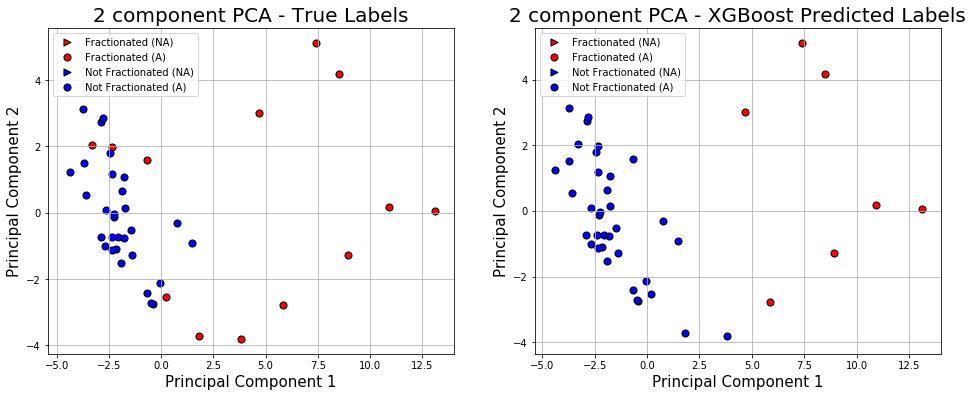

In [37]:
fig = plt.figure(figsize = (16,6))
ax1 = fig.add_subplot(1,2,1) 
ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)
ax1.set_title('2 component PCA - True Labels', fontsize = 20)
labels = [1, 0]
colors = ['r', 'b']
augmented = [1,0]
markers = ['o', '>']
for label, color in zip(labels,colors):
    for aug in augmented:
        idx_to_keep = ((final_df['Label'].values == label) & (final_df['Augmented'] == aug))
        ax1.scatter(final_df.loc[idx_to_keep, 'principal component 1']
                   , final_df.loc[idx_to_keep, 'principal component 2']
                   , c = color
                   , marker = markers[aug]
                   , edgecolors = 'k'
                   , s = 50)
ax1.legend(['Fractionated (NA)', 'Fractionated (A)', 
            'Not Fractionated (NA)', 'Not Fractionated (A)'])
ax1.grid()

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel('Principal Component 1', fontsize = 15)
ax2.set_ylabel('Principal Component 2', fontsize = 15)
ax2.set_title('2 component PCA - XGBoost Predicted Labels', fontsize = 20)
predictions = [1, 0]
colors = ['r', 'b']

for prediction, color in zip(predictions,colors):
    for aug in augmented:
        idx_to_keep = ((final_df['XGBoost Predictions'].values == prediction) & (final_df['Augmented'] == aug))
        ax2.scatter(final_df.loc[idx_to_keep, 'principal component 1']
                   , final_df.loc[idx_to_keep, 'principal component 2']
                   , c = color
                   , marker = markers[aug]
                   , edgecolors = 'k'
                   , s = 50)
ax2.legend(['Fractionated (NA)', 'Fractionated (A)', 
            'Not Fractionated (NA)', 'Not Fractionated (A)'])
ax2.grid()